# Virtual Screening

## Objectives

- Realizar triagem virtual no PubChem usando uma abordagem baseada em ligantes.
- Aplicar filtros para priorizar a lista de compostos candidatos para triagem virtual.
- Aprender a usar o Pandas para manipulação de dados.

O objetivo deste notebook é realizar uma triagem virtual no PubChem usando uma abordagem baseada em ligantes. Isso envolve a seleção de compostos candidatos com base em critérios específicos, como propriedades químicas e estruturais, a partir de uma lista de compostos conhecidos.

## 1. O objetivo desta etapa é ler ligantes conhecidos de um arquivo.

Como ponto de partida, vamos baixar um conjunto de ligantes conhecidos contra a ACES - Acetilcolinesterase. Esses dados são obtidos dos conjuntos de dados DUD-E (Directory of Useful Decoys, Enhanced) (//dude.docking.org/), que contêm ativos e inativos conhecidos para 102 alvos proteicos. Os conjuntos DUD-E são amplamente utilizados em estudos de benchmarking que comparam o desempenho de diferentes abordagens de triagem virtual (https://doi.org/10.1021/jm300687e).

In [1]:
import pandas as pd

In [2]:
colnames = ['smiles','dat', 'id']
df_act = pd.read_csv("../dataset/formats/actives_final.ism", sep=" ", names=colnames)
df_act.head(5)

,smiles,dat,id
0,Clc5ccc4c(NCCCCCNC(=O)CCCc1c[nH]c2ccccc12)c3CC...,374466,CHEMBL225021
1,CC(C)(C)c1cccc(C(=O)C(F)(F)F)c1,142855,CHEMBL89354
2,Clc5cc(Cl)c4c(NCCCCCCC(=O)NCCc1c[nH]c2ccccc12)...,335625,CHEMBL199585
3,Clc5ccc4c(NCCCCCCCNC(=O)CCc1c[nH]c2ccccc12)c3C...,374504,CHEMBL225198
4,CNC(=O)Oc4cccc(CN(C)CCCOc3ccc2c(=O)c1cccnc1oc2...,213761,CHEMBL131827


In [3]:
print(len(df_act))    # Mostre quantas estruturas estão no "data frame"

453


## 2. Pesquisa de similaridade com a PubChem

Nesta etapa, você realizará uma pesquisa de similaridade no PubChem usando cada composto ativo conhecido como uma consulta. Aqui estão algumas coisas a serem observadas nesta etapa:

- Você tem as cadeias de caracteres SMILES isoméricos disponíveis para cada composto de consulta. Você usará essa string para especificar a estrutura de entrada, portanto, usará o HTTP POST para enviar as consultas. Certifique-se de revisar as informações sobre entrada de estruturas no arquivo "lecture02-structure-inputs.ipynb".

- Durante a pesquisa de similaridade no PubChem, a similaridade molecular é avaliada usando as impressões digitais do PubChem e o coeficiente de Tanimoto. Por padrão, a pesquisa de similaridade retornará compostos com pontuações de Tanimoto de 0,9 ou superior. Neste exercício, usaremos o limite padrão, mas é importante notar que ele é ajustável. Se você usar um limite mais alto (por exemplo, 0,99), obterá menos resultados, que são muito semelhantes aos compostos de consulta. Se você usar um limite mais baixo (por exemplo, 0,88), obterá mais resultados, mas eles incluirão mais falsos positivos.

- A pesquisa de similaridade no PubChem não retorna as pontuações de similaridade entre os compostos de consulta e os compostos encontrados. Apenas a lista de compostos encontrados é retornada, o que torna difícil classar os compostos para seleção. Para contornar esse problema, você calculará o número de compostos de consulta que retornaram um determinado composto como resultado. A suposição subjacente é que os compostos que foram retornados várias vezes por diferentes consultas têm maior probabilidade de serem ativos do que aqueles retornados apenas uma vez por uma única consulta.

- Adicione time.sleep() para evitar sobrecarregar os servidores do PubChem e ser bloqueado.

Neste ponto, você deve ter os dados dos compostos ativos conhecidos e está pronto para realizar a pesquisa de similaridade no PubChem. Certifique-se de seguir as instruções acima e use a biblioteca requests em Python para enviar as consultas e receber os resultados.

In [4]:
smiles_act = df_act.smiles.to_list()

In [8]:
import time
import requests

prolog = "https://pubchem.ncbi.nlm.nih.gov/rest/pug"

cids_hit = dict()

for idx, mysmiles in enumerate(smiles_act) :
    
    mydata = { 'smiles' : mysmiles }
    
    url = prolog + "/compound/fastsimilarity_2d/smiles/cids/txt"
    res = requests.post(url, data=mydata)

    if ( res.status_code == 200 ) :
        cids = res.text.split()
        cids = [ int(x) for x in cids ]    # Convert CIDs from string to integer.
    else :
        print("Error at", idx, ":", df_act.loc[idx,'id'], mysmiles )
        print(res.status_code)
        print(res.content)
    
    for mycid in cids:
        cids_hit[mycid] = cids_hit.get(mycid, 0) + 1
    
    time.sleep(0.2)

In [9]:
len(cids_hit)    # Mostre o número de compostos retornados de qualquer consulta.

159468

Nas células de código acima, os acertos retornados são armazenados em um dicionário, junto com o número de vezes que são retornados. Vamos imprimir os 10 principais compostos que são retornados mais vezes na pesquisa.

In [10]:
sorted_by_freq = [ (v, k) for k, v in cids_hit.items() ]
sorted_by_freq.sort(reverse=True)

for v, k in enumerate(sorted_by_freq) :

    if v == 10 : 
        break
    
    print(v, k) # Imprimir (frequência, CID)
    

0 (33, 154409533)
1 (33, 88265278)
2 (33, 53437291)
3 (33, 44531955)
4 (33, 44387824)
5 (33, 24879379)
6 (33, 23299023)
7 (33, 11800131)
8 (33, 11410045)
9 (33, 10744885)


## 3. Exclua os compostos de consulta dos hits

Nesta etapa, você excluirá os compostos de consulta dos resultados da pesquisa de similaridade. Como você realizou várias pesquisas de similaridade usando várias moléculas de consulta, é possível que uma molécula de consulta seja retornada como um resultado de pesquisa de similaridade usando outra molécula de consulta. Portanto, você deseja verificar se a lista de compostos encontrados contém alguma molécula de consulta e, se sim, removê-las. Abaixo, você pesquisará o PubChem por compostos idênticos às moléculas de consulta e os removerá da lista de compostos encontrados.

Observe que o parâmetro identity_type na solicitação PUG-REST está definido como "same_connectivity", o que retornará compostos com a mesma conectividade que a molécula de consulta (ignorando informações de estereoisomeria e isótopos). O padrão para este parâmetro é "same_stereo_isotope", que retorna compostos com a mesma estereoquímica E informações de isótopos.

Essa etapa é importante para garantir que os compostos de consulta não sejam incluídos nos resultados finais, pois você deseja identificar novos compostos potencialmente ativos. Certifique-se de implementar essa exclusão corretamente em seus resultados da pesquisa de similaridade.

In [11]:
cids_query = dict()

for idx, mysmiles in enumerate(smiles_act) :
    
    mydata = { 'smiles' : mysmiles }
    url = prolog + "/compound/fastidentity/smiles/cids/txt?identity_type=same_connectivity"
    res = requests.post(url, data=mydata)

    if ( res.status_code == 200 ) :
        cids = res.text.split()
        cids = [ int(x) for x in cids]
    else :
        print("Error at", idx, ":", df_act.loc[idx,'id'], mysmiles )
        print(res.status_code)
        print(res.content)
       
    for mycid in cids:
        cids_query[mycid] = cids_query.get(mycid, 0) + 1
    
    time.sleep(0.2)

Error at 294 : CHEMBL1085030 CN(CCOCCNC(=S)NC(=O)c1ccc3c(c1)c(=O)c2ccccc23)Cc4ccccc4
404
b'Status: 404\nCode: PUGREST.NotFound\nMessage: Identity search returned no hits\n'
Error at 296 : CHEMBL100819 CN(CCOCCNC(=S)NC(=O)c3ccc2c(=O)c1ccccc1c2c3)Cc4ccccc4
404
b'Status: 404\nCode: PUGREST.NotFound\nMessage: Identity search returned no hits\n'
Error at 311 : CHEMBL273051 O=C(CON=N(=O)N1CCCC1)NCCCNc3c2CCCCc2nc4ccccc34
500
b'Status: 500\nCode: PUGREST.ServerError\nMessage: Identity search status indicates failure\n'
Error at 361 : CHEMBL260964 O=C(CON=N(=O)N1CCCC1)NCCCCNc3c2CCCCc2nc4ccccc34
500
b'Status: 500\nCode: PUGREST.ServerError\nMessage: Identity search status indicates failure\n'
Error at 424 : CHEMBL349694 O=C(NC(=S)NCCC2CCN(Cc1ccccc1)CC2)c3ccc5c(c3)c(=O)c4ccccc45
404
b'Status: 404\nCode: PUGREST.NotFound\nMessage: Identity search returned no hits\n'


In [12]:
len(cids_query.keys())    # Mostre o número de CIDs que representam os compostos da consulta.

886

Agora remova os compostos de consulta da lista de ocorrências (se forem encontrados na lista)

In [13]:
for mycid in cids_query.keys() :
    
    cids_hit.pop(mycid, None)

In [14]:
len(cids_hit)

158595

Imprima os 10 principais compostos da lista de ocorrências atual e compare-os com os antigos.

In [15]:
sorted_by_freq = [ (v, k) for k, v in cids_hit.items() ]
sorted_by_freq.sort(reverse=True)

for v, k in enumerate(sorted_by_freq) :
    
    if v == 10 : 
        break
    
    print(v, k)    # Imprimir (frequência, CID)


0 (33, 154409533)
1 (33, 88265278)
2 (33, 53437291)
3 (33, 44531955)
4 (33, 44387824)
5 (33, 24879379)
6 (33, 23299023)
7 (33, 11410045)
8 (33, 10625415)
9 (33, 9984054)


## 4. Filtrando compostos não semelhantes a medicamentos

Nesta etapa, os compostos que não são adequados para medicamentos são filtrados da lista. Para fazer isso, quatro propriedades moleculares são baixadas do PubChem e armazenadas em formato CSV. Essas propriedades moleculares provavelmente estão relacionadas à "drug-likeness", ou seja, à adequação de uma molécula para ser desenvolvida como um medicamento. Filtros desse tipo ajudam a reduzir a lista de compostos para aqueles que têm maior probabilidade de serem úteis como candidatos a medicamentos.

As quatro propriedades moleculares baixadas podem variar, mas geralmente incluem características como peso molecular, logP (coeficiente de partição octanol-água), número de doadores de ligação de hidrogênio e número de aceitadores de ligação de hidrogênio. Essas características são frequentemente usadas como critérios iniciais para avaliar a adequação de uma molécula como um candidato a medicamento.

Portanto, nesta etapa, você estará implementando filtros com base nessas propriedades para identificar os compostos que têm maior probabilidade de serem "drug-like" e adequados para desenvolvimento adicional como medicamentos. Certifique-se de entender as faixas aceitáveis para cada propriedade e aplique os filtros de acordo com esses critérios.

In [16]:
chunk_size = 100

if ( len(cids_hit) % chunk_size == 0 ) :
    num_chunks = len(cids_hit) // chunk_size 
else :
    num_chunks = len(cids_hit) // chunk_size + 1

cids_list = list(cids_hit.keys())
    
print("# Number of chunks:", num_chunks )

csv = ""   #define uma variável chamada csv para salvar a saída separada por vírgula

for i in range(num_chunks) :
    
    print(i, end=" ")
    
    idx1 = chunk_size * i
    idx2 = chunk_size * (i + 1)

    cids_str = ",".join([ str(x) for x in cids_list[idx1:idx2] ]) # construir entrada pug para chunks de dados
    url = prolog + "/compound/cid/" + cids_str + "/property/HBondDonorCount,HBondAcceptorCount,MolecularWeight,XLogP,CanonicalSMILES,IsomericSMILES/csv"
    
    res = requests.get(url)
    
    if ( i == 0 ) : # se esta for a primeira solicitação, armazene o resultado em uma variável csv vazia
        csv = res.text 
    else :          # se esta for uma solicitação subsequente, adicione a solicitação à variável csv adicionando uma nova linha entre os chunks
        csv = csv + "\n".join(res.text.split()[1:]) + "\n" 
      
    time.sleep(0.2)

#print(csv)

# Number of chunks: 1586
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 2

Os dados baixados (em CSV) são carregados em um quadro de dados do pandas.

In [17]:
from io import StringIO

csv_file = StringIO(csv)

df_raw = pd.read_csv(csv_file, sep=",")

df_raw.shape    # Mostra a forma (dimensão) do dataframe

(158595, 7)

In [18]:
df_raw.head(5)    # Mostrar as primeiras 5 linhas do quadro de dados

,CID,HBondDonorCount,HBondAcceptorCount,MolecularWeight,XLogP,CanonicalSMILES,IsomericSMILES
0,11669798,3,3,461.0,6.2,C1CCC2=NC3=C(C=CC(=C3)Cl)C(=C2C1)NCCCCCNC(=O)C...,C1CCC2=NC3=C(C=CC(=C3)Cl)C(=C2C1)NCCCCCNC(=O)C...
1,11478767,3,3,582.0,7.7,C1CCC2=NC3=C(C=CC(=C3)Cl)C(=C2C1)NCCCCCCCNC(=O...,C1CCC2=NC3=C(C=CC(=C3)Cl)C(=C2C1)NCCCCCCCNC(=O...
2,11465956,3,3,489.0,7.1,C1CCC2=NC3=C(C=CC(=C3)Cl)C(=C2C1)NCCCCCCCNC(=O...,C1CCC2=NC3=C(C=CC(=C3)Cl)C(=C2C1)NCCCCCCCNC(=O...
3,11316986,3,3,454.6,5.8,C1CCC2=NC3=CC=CC=C3C(=C2C1)NCCCCCNC(=O)CCC4=CN...,C1CCC2=NC3=CC=CC=C3C(=C2C1)NCCCCCNC(=O)CCC4=CN...
4,11156231,3,4,497.7,5.5,CN(CCCNC1=C2CCCCC2=NC3=CC=CC=C31)CCCNC(=O)CCC4...,CN(CCCNC1=C2CCCCC2=NC3=CC=CC=C31)CCCNC(=O)CCC4...


Observe que alguns compostos não possuem valores XLogP calculados (porque o algoritmo XLogP não pode lidar com compostos inorgânicos, sais e misturas) e queremos removê-los.

In [19]:
df_raw.isna().sum()    # Verifique se há algum valor NULL.

CID                       0
HBondDonorCount           0
HBondAcceptorCount        0
MolecularWeight           0
XLogP                 16086
CanonicalSMILES           0
IsomericSMILES            0
dtype: int64

In [20]:
len(df_raw)    # Verifique o número de linhas (que é igual ao número de CIDs)

158595

Por conveniência, adicione as informações contidas no dicionário cids_hit a este quadro de dados

In [21]:
# Primeiro carregue o dicionário cids_hit em um quadro de dados.
df_freq = pd.DataFrame( cids_hit.items(), columns=['CID','HitFreq'])
df_freq.head(5)

,CID,HitFreq
0,11669798,16
1,11478767,10
2,11465956,16
3,11316986,11
4,11156231,10


In [22]:
# Verifique novamente se os dados estão carregados corretamente
# Compare os dados com os da Cell [12]
df_freq.sort_values(by=['HitFreq', 'CID'], ascending=False).head(10)

,CID,HitFreq
5268,154409533,33
5518,88265278,33
6304,53437291,33
5763,44531955,33
4746,44387824,33
4761,24879379,33
5777,23299023,33
4550,11410045,33
4507,10625415,33
5913,9984054,33


In [23]:
# Crie um novo quadro de dados chamado "df" unindo os quadros de dados df e df_freq
df = df_raw.join(df_freq.set_index('CID'), on='CID')
df.shape

(158595, 8)

In [24]:
df.sort_values(by=['HitFreq', 'CID'], ascending=False).head(10)

,CID,HBondDonorCount,HBondAcceptorCount,MolecularWeight,XLogP,CanonicalSMILES,IsomericSMILES,HitFreq
5268,154409533,2,5,499.6,7.1,C1=CC=C2C(=C1)C(=C3C=CC=CC3=N2)NCCCCN(CCCN)C4=...,C1=CC=C2C(=C1)C(=C3C=CC=CC3=N2)NCCCCN(CCCN)C4=...,33
5518,88265278,2,5,499.6,6.5,C1=CC=C2C(=C1)C(=C3C=CC=CC3=N2)N(CCCCNCCCN)C4=...,C1=CC=C2C(=C1)C(=C3C=CC=CC3=N2)N(CCCCNCCCN)C4=...,33
6304,53437291,3,6,556.7,7.3,C1=CC=C2C(=C1)C(=C3C=CC=CC3=N2)NCCCN(CCCCN)CCC...,C1=CC=C2C(=C1)C(=C3C=CC=CC3=N2)NCCCN(CCCCN)CCC...,33
5763,44531955,2,4,550.7,10.0,C1=CC=C(C=C1)C2=NC3=CC=CC=C3C(=C2)NCCCCCCCCNC4...,C1=CC=C(C=C1)C2=NC3=CC=CC=C3C(=C2)NCCCCCCCCNC4...,33
4746,44387824,2,5,529.7,8.1,C=CCN(CCCNC1=C2CCCCC2=NC3=CC=CC=C31)CCCNC4=C5C...,C=CCN(CCCNC1=C2CCCCC2=NC3=CC=CC=C31)CCCNC4=C5C...,33
4761,24879379,2,5,547.8,8.3,C=CCN(CCCCNC1=C2CCCCC2=NC3=CC=CC=C31)CCCNC4=C5...,C=CCN(CCCCNC1=C2CCCCC2=NC3=CC=CC=C31)CCCNC4=C5...,33
5777,23299023,2,5,499.6,6.5,C1=CC=C2C(=C1)C(=C3C=CC=CC3=N2)N(CCCNCCCCN)C4=...,C1=CC=C2C(=C1)C(=C3C=CC=CC3=N2)N(CCCNCCCCN)C4=...,33
4550,11410045,2,5,533.7,8.0,C=CCN(CCCNC1=C2CCCCC2=NC3=CC=CC=C31)CCCNC4=C5C...,C=CCN(CCCNC1=C2CCCCC2=NC3=CC=CC=C31)CCCNC4=C5C...,33
4507,10625415,2,4,506.7,9.1,C1CCC2=NC3=CC=CC=C3C(=C2C1)NCCCCCCCCNC4=C5CCCC...,C1CCC2=NC3=CC=CC=C3C(=C2C1)NCCCCCCCCNC4=C5CCCC...,33
5913,9984054,2,4,516.7,9.7,C1CCC2=NC3=CC=CC=C3C(=C2C1)NCCCCCCCCCNC4=C5C=C...,C1CCC2=NC3=CC=CC=C3C(=C2C1)NCCCCCCCCCNC4=C5C=C...,33


Agora identifique e remova os compostos que satisfazem todos os critérios da regra dos cinco de Lipinski.

In [25]:
len(df[ df['HBondDonorCount'] <= 5 ])

158358

In [26]:
len(df[ df['HBondAcceptorCount'] <= 10 ])

157828

In [27]:
len(df[ df['MolecularWeight'] <= 500 ])

146837

In [28]:
len(df[ df['XLogP'] < 5 ])

119056

In [29]:
df = df[ ( df['HBondDonorCount'] <= 5) &
         ( df['HBondAcceptorCount'] <= 10 ) &
         ( df['MolecularWeight'] <= 500 ) &
         ( df['XLogP'] < 5 ) ]

In [30]:
len(df)

117379

## 5. Desenhe as estruturas dos 10 principais compostos

Nesta etapa, você irá desenhar as estruturas dos 10 melhores compostos da lista de hits. Isso é importante para visualizar as estruturas químicas desses compostos e determinar se eles têm alguma característica relevante para o seu projeto de triagem virtual. A visualização das estruturas químicas pode ajudar na seleção de compostos promissores para testes posteriores.

Você pode usar ferramentas e bibliotecas de química computacional para gerar representações gráficas das estruturas químicas dos compostos. Alguns exemplos incluem a biblioteca RDKit em Python ou software de desenho molecular especializado.

Certifique-se de que as estruturas químicas sejam exibidas com clareza e que você possa identificar características importantes, como grupos funcionais, ligações químicas e outros detalhes relevantes.

Essa etapa é fundamental para a análise visual dos compostos e pode ajudar na tomada de decisões sobre quais compostos merecem uma investigação mais aprofundada em seu projeto de triagem virtual.

In [31]:
cids_top = df.sort_values(by=['HitFreq', 'CID'], ascending=False).head(10).CID.to_list()

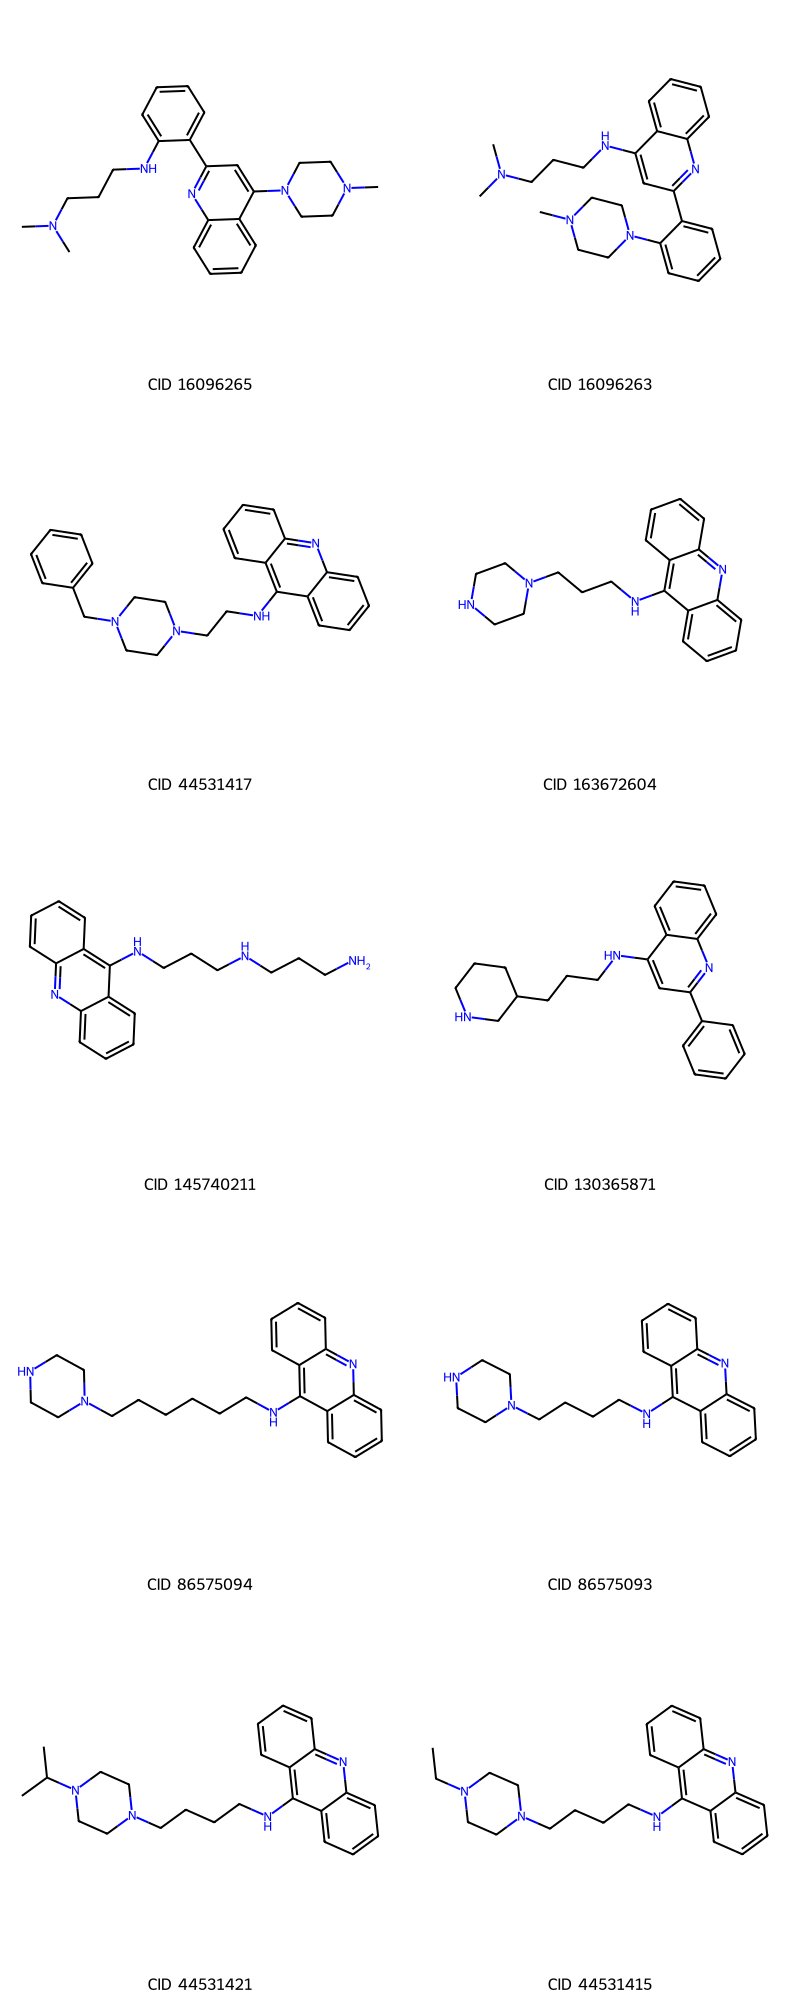

In [32]:
from rdkit import Chem
from rdkit.Chem import Draw

mols = []

for mycid in cids_top :
    
    mysmiles = df[ df.CID==mycid ].IsomericSMILES.item()
    
    mol = Chem.MolFromSmiles( mysmiles )
    Chem.FindPotentialStereoBonds(mol)    # Identifique potenciais ligações estéreo!
    mols.append(mol)

mylegends = [ "CID " + str(x) for x in cids_top ]
img = Draw.MolsToGridImage(mols, molsPerRow=2, subImgSize=(400,400), legends=mylegends)
display(img)

Uma observação importante dessas imagens é que a lista de acertos contém vários compostos com a mesma conectividade. Por exemplo, os CIDs 93077065 e 93077064 são estereoisômeros um do outro e o CID 53013349 tem a mesma conectividade que os dois CIDs, mas com seu estereocentro não especificado. Ao realizar uma triagem com recursos limitados na fase inicial da descoberta do medicamento, você pode querer testar moléculas tão diversas quanto possível, evitando testar estruturas muito semelhantes.

Para fazer isso, vamos dar uma olhada nas strings SMILES canônicas do PubChem, que não codificam a estereoquímica e as informações isotópicas. Produtos químicos com a mesma conectividade, mas com estereoquímica/isótopos diferentes devem ter os mesmos SMILES canônicos. Na próxima seção, selecionamos compostos únicos em termos de SMILES canônicos para reduzir o número de compostos a serem selecionados.

## 6. Extraia compostos únicos em termos de SMILES canônicos

Nesta etapa, você está extraindo os compostos exclusivos com base em SMILES canônicos. Isso é importante para remover compostos redundantes da sua lista de hits de triagem virtual. Os SMILES canônicos são representações padronizadas das estruturas químicas dos compostos e podem ser usados para identificar compostos idênticos ou equivalentes.

Para fazer isso, você provavelmente está usando a biblioteca pandas em Python para trabalhar com seus dados. A função drop_duplicates() pode ser útil para remover duplicatas com base em uma coluna específica, como os SMILES canônicos.

Após essa etapa, você deve ter uma lista de compostos únicos em termos de SMILES canônicos, o que simplifica a análise e a seleção dos compostos a serem considerados em seu projeto de triagem virtual. Isso garante que você não esteja repetindo a análise de compostos idênticos ou equivalentes.

In [33]:
len(df)

117379

In [34]:
len(df.CanonicalSMILES.unique())

101100

In [35]:
canonical_smiles = df.CanonicalSMILES.unique()

In [36]:
df[ df.CanonicalSMILES == canonical_smiles[0] ]

,CID,HBondDonorCount,HBondAcceptorCount,MolecularWeight,XLogP,CanonicalSMILES,IsomericSMILES,HitFreq
6,16723801,1,2,389.9,4.2,C1=CC=C2C(=C1)C(=CN2CC3=CC=C(C=C3)Cl)CCC(=O)NC...,C1=CC=C2C(=C1)C(=CN2CC3=CC=C(C=C3)Cl)CCC(=O)NC...,9


In [37]:
df[ df.CanonicalSMILES == canonical_smiles[1] ]

,CID,HBondDonorCount,HBondAcceptorCount,MolecularWeight,XLogP,CanonicalSMILES,IsomericSMILES,HitFreq
14,4782931,2,1,326.8,4.1,C1=CC=C2C(=C1)C(=CN2)CCC(=O)NCCC3=CC=C(C=C3)Cl,C1=CC=C2C(=C1)C(=CN2)CCC(=O)NCCC3=CC=C(C=C3)Cl,9


In [38]:
df[ df.CanonicalSMILES == canonical_smiles[1] ].IsomericSMILES.to_list()

['C1=CC=C2C(=C1)C(=CN2)CCC(=O)NCCC3=CC=C(C=C3)Cl']

Agora vamos gerar uma lista de compostos únicos em termos de SMILES canônicos. Se vários compostos tiverem os mesmos SMILES canônicos, aquele que aparecer primeiro será incluído na lista de compostos exclusivos.

In [39]:
idx_to_include = []

for mysmiles in canonical_smiles :

    myidx = df[ df.CanonicalSMILES == mysmiles ].index.to_list()[0]
    
    idx_to_include.append( myidx )

In [40]:
len(idx_to_include)

101100

In [41]:
# Crie uma nova coluna 'Incluir'
# Todos os valores inicializados em 0 (não incluídos)
df['Include'] = 0
df['Include'].sum()

0

In [42]:
# Agora o valor da coluna "Include" é modificado se o registro estiver na lista idx_to_include.
df.loc[idx_to_include,'Include'] = 1
df['Include'].sum()

101100

In [43]:
df[['CID','Include']].head(10)

,CID,Include
6,16723801,1
14,4782931,1
39,145950271,1
46,118705964,1
55,42743586,1
56,42743569,1
60,9978527,1
61,6457960,1
62,2704817,1
63,168280844,1


Agora desenhe os 10 principais compostos exclusivos (em termos de SMILES canônicos). Observe que as figuras da estrutura são desenhadas usando SMILES isoméricos, mas strings canônicas de SMILES podem ser usadas.

In [44]:
cids_top = df[ df['Include'] == 1].sort_values(by=['HitFreq', 'CID'], ascending=False).head(10).CID.to_list()

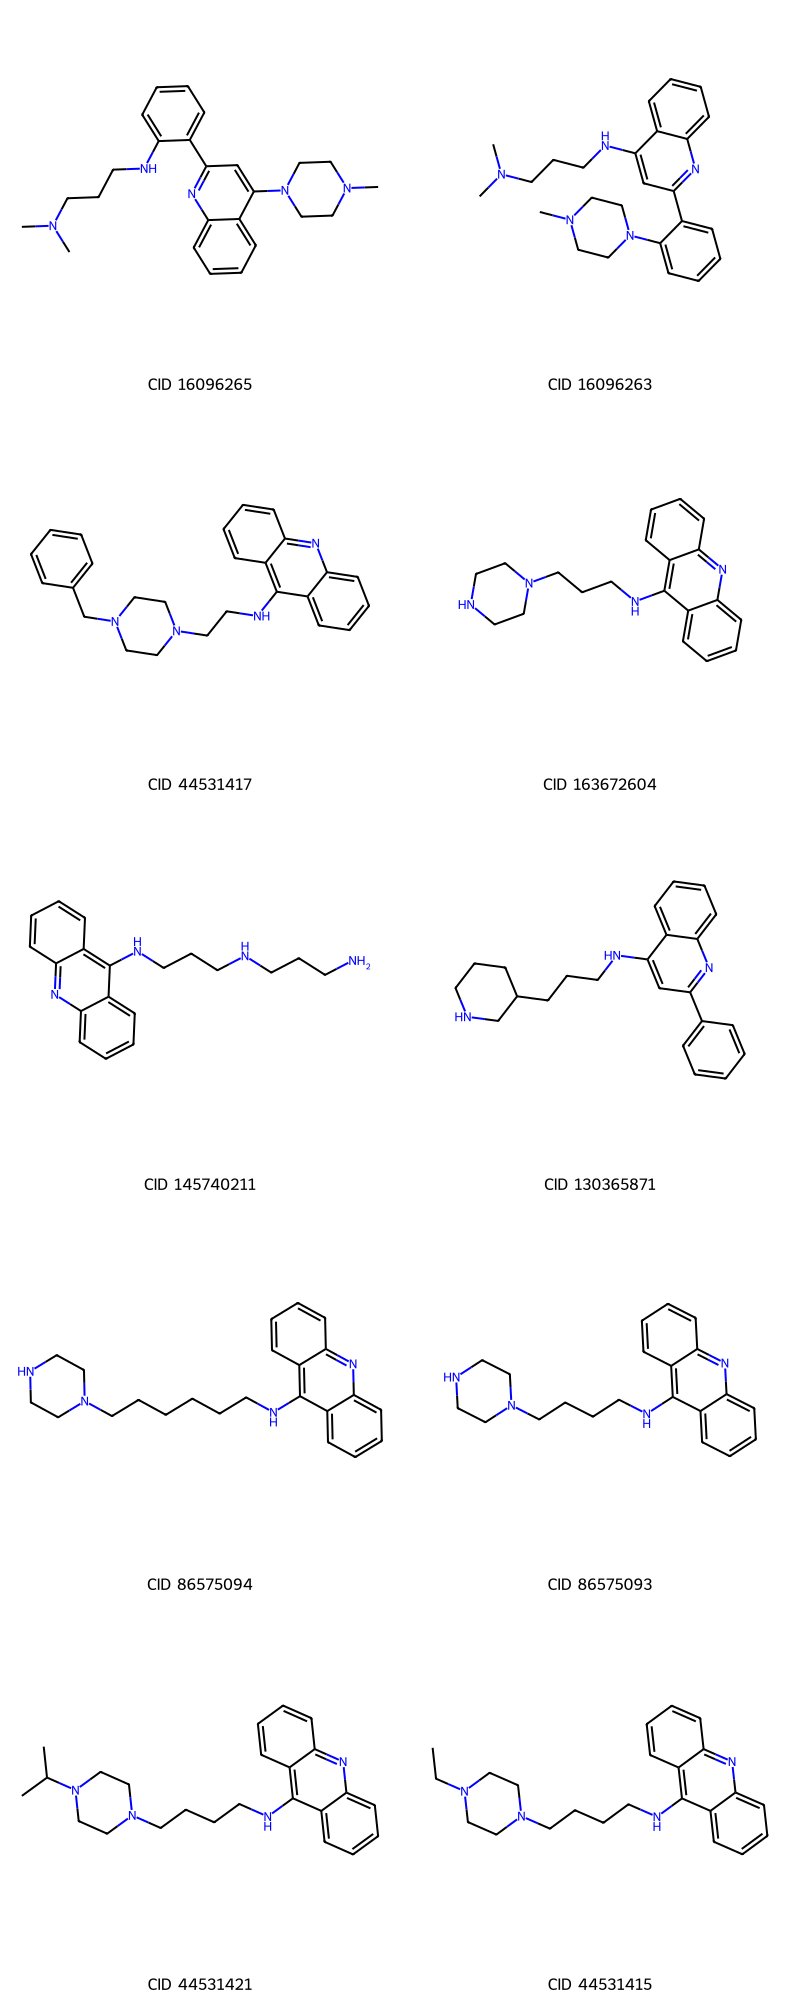

In [45]:
mols = []

for mycid in cids_top :
    
    mysmiles = df[ df.CID==mycid ].IsomericSMILES.item()
    
    mol = Chem.MolFromSmiles( mysmiles )
    Chem.FindPotentialStereoBonds(mol)    # Identifique potenciais ligações estéreo!
    mols.append(mol)

mylegends = [ "CID " + str(x) for x in cids_top ]
img = Draw.MolsToGridImage(mols, molsPerRow=2, subImgSize=(400,400), legends=mylegends)
display(img)

## 7. Salvando moléculas em arquivos

Nesta etapa, você está salvando os compostos da lista cids_top em arquivos separados. Esses arquivos serão usados posteriormente em experimentos de ancoragem molecular. Você mencionou que está interessado apenas nos três principais compostos da lista.

Para realizar essa tarefa, você pode usar uma biblioteca química, como a RDKit, para trabalhar com as estruturas químicas dos compostos e salvar essas estruturas em formato de arquivo químico, como Mol ou SDF.

In [46]:
from rdkit.Chem import AllChem

for idx, mycid in enumerate( cids_top ) :

    if idx == 3 :
        break
        
    mysmiles = df[ df['CID'] == mycid ].IsomericSMILES.item()

    mymol = Chem.MolFromSmiles(mysmiles)
    mymol = Chem.AddHs(mymol)
    AllChem.EmbedMolecule(mymol)
    AllChem.MMFFOptimizeMolecule(mymol)

    filename = "pygm_lig" + str(idx) + "_" + str(mycid) + ".mol"
    Chem.MolToMolFile(mymol, filename)


Para salvar todos os dados no quadro de dados df (em CSV)

In [47]:
df = pd.read_csv("./pygm_df.csv", delimiter= ",")

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84996 entries, 0 to 84995
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          84996 non-null  int64  
 1   CID                 84996 non-null  int64  
 2   HBondDonorCount     84996 non-null  int64  
 3   HBondAcceptorCount  84996 non-null  int64  
 4   MolecularWeight     84996 non-null  float64
 5   XLogP               84996 non-null  float64
 6   CanonicalSMILES     84996 non-null  object 
 7   IsomericSMILES      84996 non-null  object 
 8   HitFreq             84996 non-null  int64  
 9   Include             84996 non-null  int64  
 10  Molecule            84993 non-null  object 
dtypes: float64(2), int64(6), object(3)
memory usage: 7.1+ MB


In [49]:
df.shape

(84996, 11)

In [ ]:
df.head(5) 

In [ ]:
from rdkit.Chem import PandasTools
PandasTools.AddMoleculeColumnToFrame(df,'CanonicalSMILES','Molecule',includeFingerprints=True)

In [ ]:
df = df.dropna(subset=['Molecule'])

In [ ]:
df.head(5)

In [ ]:
df.shape

In [ ]:
df.columns

In [ ]:
PandasTools.WriteSDF(df, '../dataset/formats/virtual_screening.sdf', molColName='Molecule', properties=list(df.columns))

In [ ]:
df = pd.read_csv("../descriptors/generate/padel/virtual_screening_padel_descriptors.csv", delimiter= ",", error_bad_lines=False)

In [ ]:
df.head()

In [ ]:
df.tail()

In [ ]:
df.shape

In [ ]:
mols = [x for x in  Chem.SDMolSupplier("../dataset/formats/virtual_screening.sdf") if x is not None]
rdkit_2d_desc = []
calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
header = calc.GetDescriptorNames()
for i in range(len(mols)):
    ds = calc.CalcDescriptors(mols[i])
    rdkit_2d_desc.append(ds)
df = pd.DataFrame(rdkit_2d_desc,columns=header)
df.to_csv('./generate/rdkit/virtual_screening_rdkit_ml_descriptors.csv')

In [ ]:
padeldescriptor(mol_dir='../dataset/formats/virtual_screening.sdf', d_file='./generate/padel/virtual_screening_padel_descriptors.csv', d_2d=True)

In [2]:
import sirms as si
! sirms -in ../dataset/formats/virtual_screening.sdf -o ./generate/sirms/virtual_screening_sirms_descriptors.txt

usage: sirms [-h] [-i input.sdf] [-o output.txt] [-b output_format]
             [-a [[...]]] [--min_atoms] [--max_atoms] [--min_components]
             [--max_components] [-q] [-m mixtures.txt] [--min_mix_components]
             [--max_mix_components]
             [--descriptors_transformation num|prob|both] [--mix_type abs|rel]
             [-r] [--mix_self_association] [--reaction_diff] [-v] [-x]
             [-f fragments.txt] [--per_atom_fragments] [-w field_name]
             [--version] [-c number_of_cores]
sirms: error: unrecognized arguments: ../dataset/formats/virtual_screening.sdf
